<h3>Network Traffic Identification with Convolution Neural Network</h3><br/>
[Research study paper](Jain_Akshit_Independent_Study_Paper.pdf) 

<h4> Import Python Libraries </h4>

In [9]:
import pandas as pd
import numpy as np
np.random.seed(2500)
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from laplotter import LossAccPlotter
from data_frequency import DataFrequency

<h4> Load Data </h4>

In [10]:
data_file = 'dataset.csv'
if (data_file):
    df = pd.read_csv(data_file, header=None)
    data_array = df.values
    x, y = [],[]
    for data in data_array:
        # payload bytes
        x.append(data[1:])
        # protocol class
        y.append(data[0])
    x = np.array(x)
    y = np.array(y)
else:
    raise IOError('Non-empty filename expected.')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,Google,22,3,1,2,0,1,0,1,252,...,113,118,108,144,87,17,63,67,134,114
1,SSL,22,3,3,0,57,2,0,0,53,...,140,123,32,18,193,74,221,192,98,78
2,LDAP,48,132,0,0,4,249,2,2,3,...,161,230,107,18,191,84,166,85,176,245
3,LDAP,48,132,0,0,5,8,2,2,3,...,168,49,160,26,52,181,64,181,202,160
4,MS_OneDrive,72,84,84,80,47,49,46,49,32,...,46,105,112,118,54,116,101,115,116,99


<h4> Protocol Frequency Distribution </h4>

In [11]:
def plot_label_frequecy(label_frequency_distribution):

    label_frequency = sorted(label_frequency_distribution.items())
    keys = sorted(label_frequency_distribution.keys())
    df_label_freq = pd.DataFrame(label_frequency[7:], index=keys[7:], \
                                    columns=['protocol','frequency'])
    df_label_freq.plot.bar(figsize=(20,15), grid=True, fontsize=16, rot=30)
    plt.xlabel('Protocol Label', fontsize=20)
    plt.ylabel('Frequency (%)', fontsize=20)
    plt.yticks(np.arange(0.0, 10.05, 0.5), fontsize=20)
    plt.show()

34929


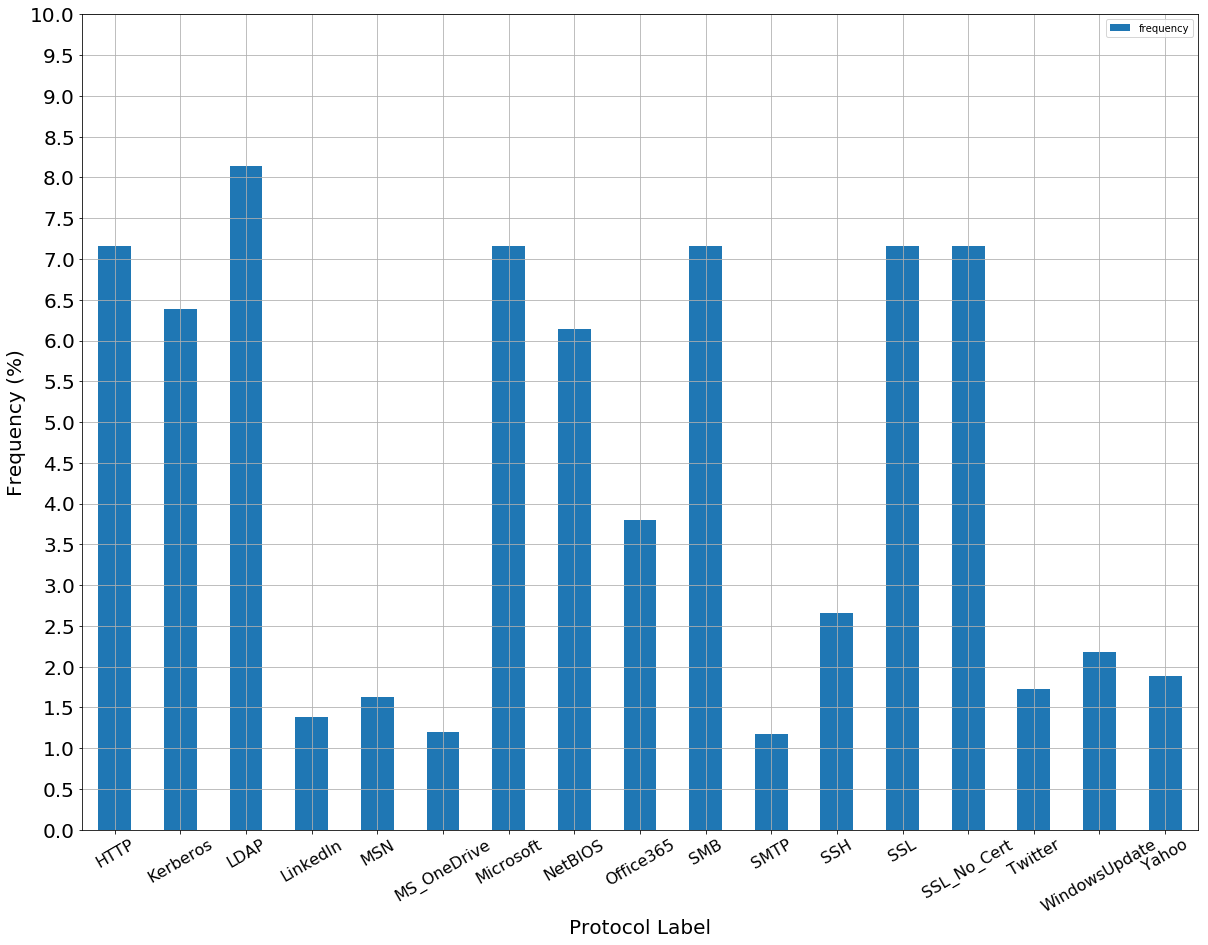

In [4]:
# Calculate protocol label frequency distribution
data_freq = DataFrequency(y)
label_frequency_distribution = data_freq.calculate_label_distribution()
# Plot bar chart
plot_label_frequecy(label_frequency_distribution)

<h4> Split Dataset for Training and Testing </h4>

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

<h4> Transform Data </h4>

In [13]:
# reshape attributes to spatial dimensions
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# one-hot-encode output labels (protocol names)
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_y_train)

encoder.fit(y_test)
# the name of the class labels encoded
class_labels = encoder.classes_
# the number of different labels being trained
nb_classes = len(class_labels)
encoded_y_test = encoder.transform(y_test)
y_test = np_utils.to_categorical(encoded_y_test)

<h4> Build a Sequential 1d-Convolutional Model </h4>

In [14]:
# Build a model
model = Sequential()
model.add(Conv1D(filters=2, kernel_size=5, activation='relu', input_shape=(1024,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1020, 2)           12        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 510, 2)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 510, 2)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1020)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                16336     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                216       
Total para

<h4> Train the model </h4>
1. Experiment with different optimizers(i.e. Adam, RMSprop, SGD-Momentum, SGD-Nesterov)
2. Set nb_epochs depending on the optimizer

In [15]:
optimizer = 'SGD-Momentum'
gd_optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False)
nb_epochs = 50
model.compile(optimizer=gd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# load model and weights from previous epochs
saved_model_file = 'models/trained_model_{}.h5'.format('conv1d-SGD-Momentum')
weights = 'weights/weight_model{}.hdf5'.format('conv1d-SGD-Momentum')
try:
    model.load_weights(weights)
except:
    pass

#save model at checkpoints when loss function improved
checkpoint = ModelCheckpoint(saved_model_file, monitor='val_loss', save_best_only=True, verbose=1)
fit_history = model.fit(x_train, y_train, epochs=nb_epochs, batch_size=32, 
                            validation_split=0.10, callbacks=[checkpoint])

# save model weights reuse later
model.save_weights(weights)
print('Model training finished')

Train on 22005 samples, validate on 2445 samples
Epoch 1/50
22005/22005 [==============================] - 10s 433us/step - loss: 2.3739 - acc: 0.4028 - val_loss: 1.7036 - val_acc: 0.5526

Epoch 00001: val_loss improved from inf to 1.70358, saving model to models/trained_model_conv1d-SGD-Momentum.h5
Epoch 2/50
22005/22005 [==============================] - 8s 380us/step - loss: 1.5877 - acc: 0.5757 - val_loss: 1.4282 - val_acc: 0.6074

Epoch 00002: val_loss improved from 1.70358 to 1.42821, saving model to models/trained_model_conv1d-SGD-Momentum.h5
Epoch 3/50
22005/22005 [==============================] - 9s 394us/step - loss: 1.3851 - acc: 0.6061 - val_loss: 1.2480 - val_acc: 0.6245

Epoch 00003: val_loss improved from 1.42821 to 1.24796, saving model to models/trained_model_conv1d-SGD-Momentum.h5
Epoch 4/50
22005/22005 [==============================] - 10s 443us/step - loss: 1.2462 - acc: 0.6329 - val_loss: 1.1306 - val_acc: 0.6658

Epoch 00004: val_loss improved from 1.24796 to 1.

22005/22005 [==============================] - 9s 418us/step - loss: 0.7633 - acc: 0.7619 - val_loss: 0.8300 - val_acc: 0.7579

Epoch 00036: val_loss did not improve
Epoch 37/50
22005/22005 [==============================] - 10s 436us/step - loss: 0.7593 - acc: 0.7650 - val_loss: 0.8024 - val_acc: 0.7587

Epoch 00037: val_loss improved from 0.81112 to 0.80245, saving model to models/trained_model_conv1d-SGD-Momentum.h5
Epoch 38/50
22005/22005 [==============================] - 9s 411us/step - loss: 0.7578 - acc: 0.7652 - val_loss: 0.8207 - val_acc: 0.7624

Epoch 00038: val_loss did not improve
Epoch 39/50
22005/22005 [==============================] - 9s 417us/step - loss: 0.7516 - acc: 0.7651 - val_loss: 0.7952 - val_acc: 0.7640

Epoch 00039: val_loss improved from 0.80245 to 0.79520, saving model to models/trained_model_conv1d-SGD-Momentum.h5
Epoch 40/50
22005/22005 [==============================] - 9s 418us/step - loss: 0.7422 - acc: 0.7691 - val_loss: 0.8029 - val_acc: 0.7587

Epo

<h4> Evaluate the model </h4>

In [16]:
model = load_model('models/trained_model_conv1d-SGD-Momentum.h5')
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
msg = "\nModel evaluation finished\nLoss: {}\tAccuracy: {}".format(loss, accuracy)
print(msg)


Model evaluation finished
Loss: 0.779885813629	Accuracy: 0.768680217584


<h4> Predict: Measure the Performance of the Model on the Dataset </h4>

In [17]:
def plot_confusion_matrix(y_labels, preds, class_labels):

    y_true_labels = [np.argmax(t) for t in y_labels]
    y_preds_labels = [np.argmax(t) for t in preds]

    cm = confusion_matrix(y_true_labels, y_preds_labels)

    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(20,15))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig = sn.heatmap(df_cm, cmap='coolwarm', xticklabels=class_labels, 
        yticklabels=class_labels[0], linewidths=.5, annot=True, fmt="d")
    plt.show()

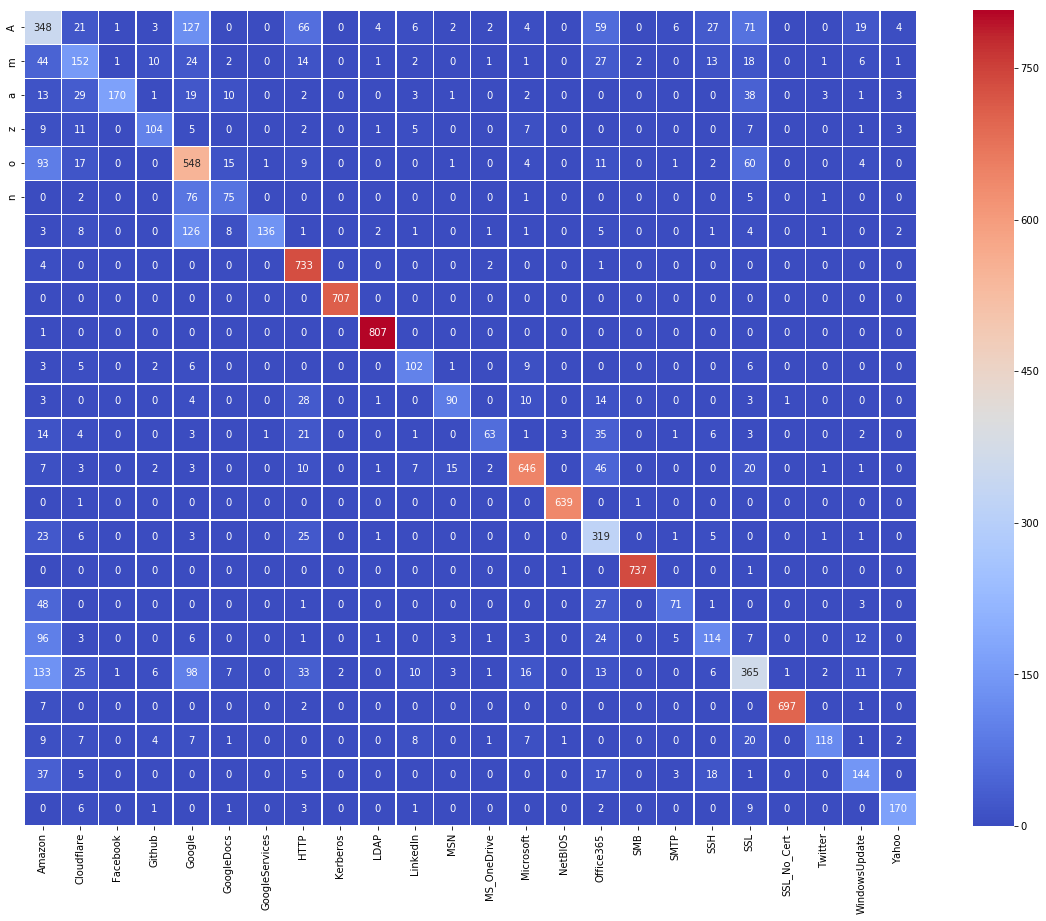

                precision    recall  f1-score   support

        Amazon     0.3888    0.4519    0.4180       770
    Cloudflare     0.4984    0.4750    0.4864       320
      Facebook     0.9827    0.5763    0.7265       295
        Github     0.7820    0.6710    0.7222       155
        Google     0.5194    0.7154    0.6019       766
    GoogleDocs     0.6303    0.4688    0.5376       160
GoogleServices     0.9855    0.4533    0.6210       300
          HTTP     0.7667    0.9905    0.8644       740
      Kerberos     0.9972    1.0000    0.9986       707
          LDAP     0.9853    0.9988    0.9920       808
      LinkedIn     0.6986    0.7612    0.7286       134
           MSN     0.7759    0.5844    0.6667       154
   MS_OneDrive     0.8514    0.3987    0.5431       158
     Microsoft     0.9073    0.8455    0.8753       764
       NetBIOS     0.9922    0.9969    0.9946       641
     Office365     0.5317    0.8286    0.6477       385
           SMB     0.9959    0.9973    0.9966  

In [18]:
preds = model.predict(x_test, batch_size=32, verbose=0)

plot_confusion_matrix(y_test, preds, class_labels)

y_true_labels = [np.argmax(t) for t in y_test]
y_preds_labels = [np.argmax(t) for t in preds]

class_metric_report = classification_report(y_true_labels, y_preds_labels, target_names=class_labels, digits=4)
print(class_metric_report)